## Read in Data

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
# Azure Machine Learning workspace details:
subscription = '58bb8a15-5d27-4d02-a5ca-772d24ae37a8'
resource_group = 'project-rg'
workspace = 'group-02-aml'
datastore_name = 'workspaceblobstore'
path_on_datastore = 'filtered-submissions-all2'

# long-form Datastore uri format:
uri = f'azureml://subscriptions/{subscription}/resourcegroups/{resource_group}/workspaces/{workspace}/datastores/{datastore_name}'
print(uri)
print(path_on_datastore)

azureml://subscriptions/58bb8a15-5d27-4d02-a5ca-772d24ae37a8/resourcegroups/project-rg/workspaces/group-02-aml/datastores/workspaceblobstore
filtered-submissions-all2


In [3]:
pip install -U azureml-fsspec mltable

Requirement already up-to-date: azureml-fsspec in /anaconda/envs/azureml_py38/lib/python3.8/site-packages (1.2.0)
Requirement already up-to-date: mltable in /anaconda/envs/azureml_py38/lib/python3.8/site-packages (1.5.0)
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
from azureml.fsspec import AzureMachineLearningFileSystem

# create the filesystem
fs = AzureMachineLearningFileSystem(uri)

# append parquet files in folder to a list
dflist = []
for path in fs.glob(f'{path_on_datastore}/*.parquet'):
    with fs.open(path) as f:
        dflist.append(pd.read_parquet(f))

# concatenate data frames
reddit_df = pd.concat(dflist)

In [5]:
reddit_df.shape
reddit_df.head(2)


,adserver_click_url,adserver_imp_pixel,archived,author,author_cakeday,author_flair_css_class,author_flair_text,author_id,brand_safe,contest_mode,...,suggested_sort,third_party_trackers,third_party_tracking,third_party_tracking_2,thumbnail,thumbnail_height,thumbnail_width,title,url,whitelist_status
0,None,None,False,[deleted],None,None,None,None,None,False,...,None,None,None,None,default,NaN,NaN,Should I move to D.C. or commute from NoVa?,,all_ads
1,None,None,False,thewheisk,None,None,None,None,None,False,...,None,None,None,None,default,NaN,NaN,ChatGPT - what should happen to a sitting memb...,https://www.reddit.com/r/Seattle/comments/119d...,all_ads


In [55]:
reddit_df = pd.concat(dflist)

In [6]:
reddit_df.reset_index(inplace=True)

# Conduct basic data text checks/analysis on your data

Prior to beginning an NLP analysis, it is always good practice to familiarize yourself with the text data you are working with. Reddit submission data is inherently full of text and therefore an initial analysis of the text was conducted. In this section, we will first look at how many submissions contain unnecessary text (e.g., removed, deleted) and remove unnecessary stop words. We will also analyze the distribution of the length of text by subreddit and by year to see if there are any significant differences. Next, we will take a first glance at the top words used in the submissions.Finally, we will create a TF-IDF visual to display the most significant words using a text vectorizer.

## 1. Count Instances of empty strings, `deleted`, and `removed`
When analyzing the Reddit submission text, it was apparent that there were a lot of submission texts that were deleted, removed, or were simply empty. Since these posts do not actually contain text, we will analyze how often they occurred and exclude them from the preliminary text analysis.

In the following cell, we will be counting how many instances of `deleted` and `removed` submissions existed in the dataset.

In [58]:
# Subset on those values
sub_df = reddit_df[reddit_df['selftext'].isin(['[deleted]', '[removed]', ''])]
sub_df = pd.DataFrame(sub_df.groupby('selftext')['selftext'].count())
sub_df.rename(columns={'selftext':'Count of Submissions'}, inplace = True)
sub_df.reset_index(inplace = True)
sub_df.rename(columns={'selftext':'Type'}, inplace = True)
sub_df.loc[0, 'Type'] = 'Empty Submission'
sub_df.loc[1, 'Type'] = 'Deleted Submission'
sub_df.loc[2, 'Type'] = 'Removed Submission'
sub_df

,Type,Count of Submissions
0,Empty Submission,82012
1,Deleted Submission,24059
2,Removed Submission,67669


In [7]:
print(f'Total number of rows before removing deleted or removed text: {reddit_df.shape}')
new_df = reddit_df[~reddit_df['selftext'].isin(['[deleted]', '[removed]', ''])]
print(f'Total number of rows after removing deleted or removed text: {new_df.shape}')

Total number of rows before removing deleted or removed text: (217394, 69)
Total number of rows after removing deleted or removed text: (43654, 69)


**Analysis:** We see a large reduction of submission rows due to the posts being empty, deleted, removed by moderators. The affected rows totaled nearly 174K. This provides insight into the trends of these subreddits because it shows that submissions being removed or deleted is not an uncommon occurrence. Additionally, there appears to be an issue with the fact that Reddit somehow allows submissions to be empty.

## 2. Analyze String Lengths
In this section, we will analyze the distribution of the submission string lengths. Subreddit posts lengths can vary significantly depending on the author, topic, and subreddit. To get a better understanding of the text for the NLP analysis, we will take a look at the varying string lengths across different angles. Examples of different angles include the year and the subreddit.

In the following cell, we create a column showing the length of the submission string. This column will then be used to show the varying distributions of the submission string lengths.

In [8]:
import warnings
warnings.filterwarnings("ignore")

# Calculate string length
new_df['raw_length'] = new_df['selftext'].apply(lambda x: len(x))
new_df[['subreddit', 'selftext', 'raw_length']].head()

,subreddit,selftext,raw_length
2,Atlanta,I have dental insurance but it's only with gre...,423
4,Seattle,From NWAC:\n\nWe’ve received preliminary infor...,567
5,Atlanta,Please I’m obsessed with chicken biscuits but ...,327
8,Atlanta,I'm looking to get some small bits of rebar an...,254
11,washingtondc,[Last weekend](https://twitter.com/KristinMink...,857


In [9]:
# Convert 'created_utc' to datetime
new_df['created_utc'] = pd.to_datetime(new_df['created_utc'])

# Extract year from 'created_utc'
new_df['year'] = new_df['created_utc'].dt.year
new_df['year'] = new_df['year'].astype('str')

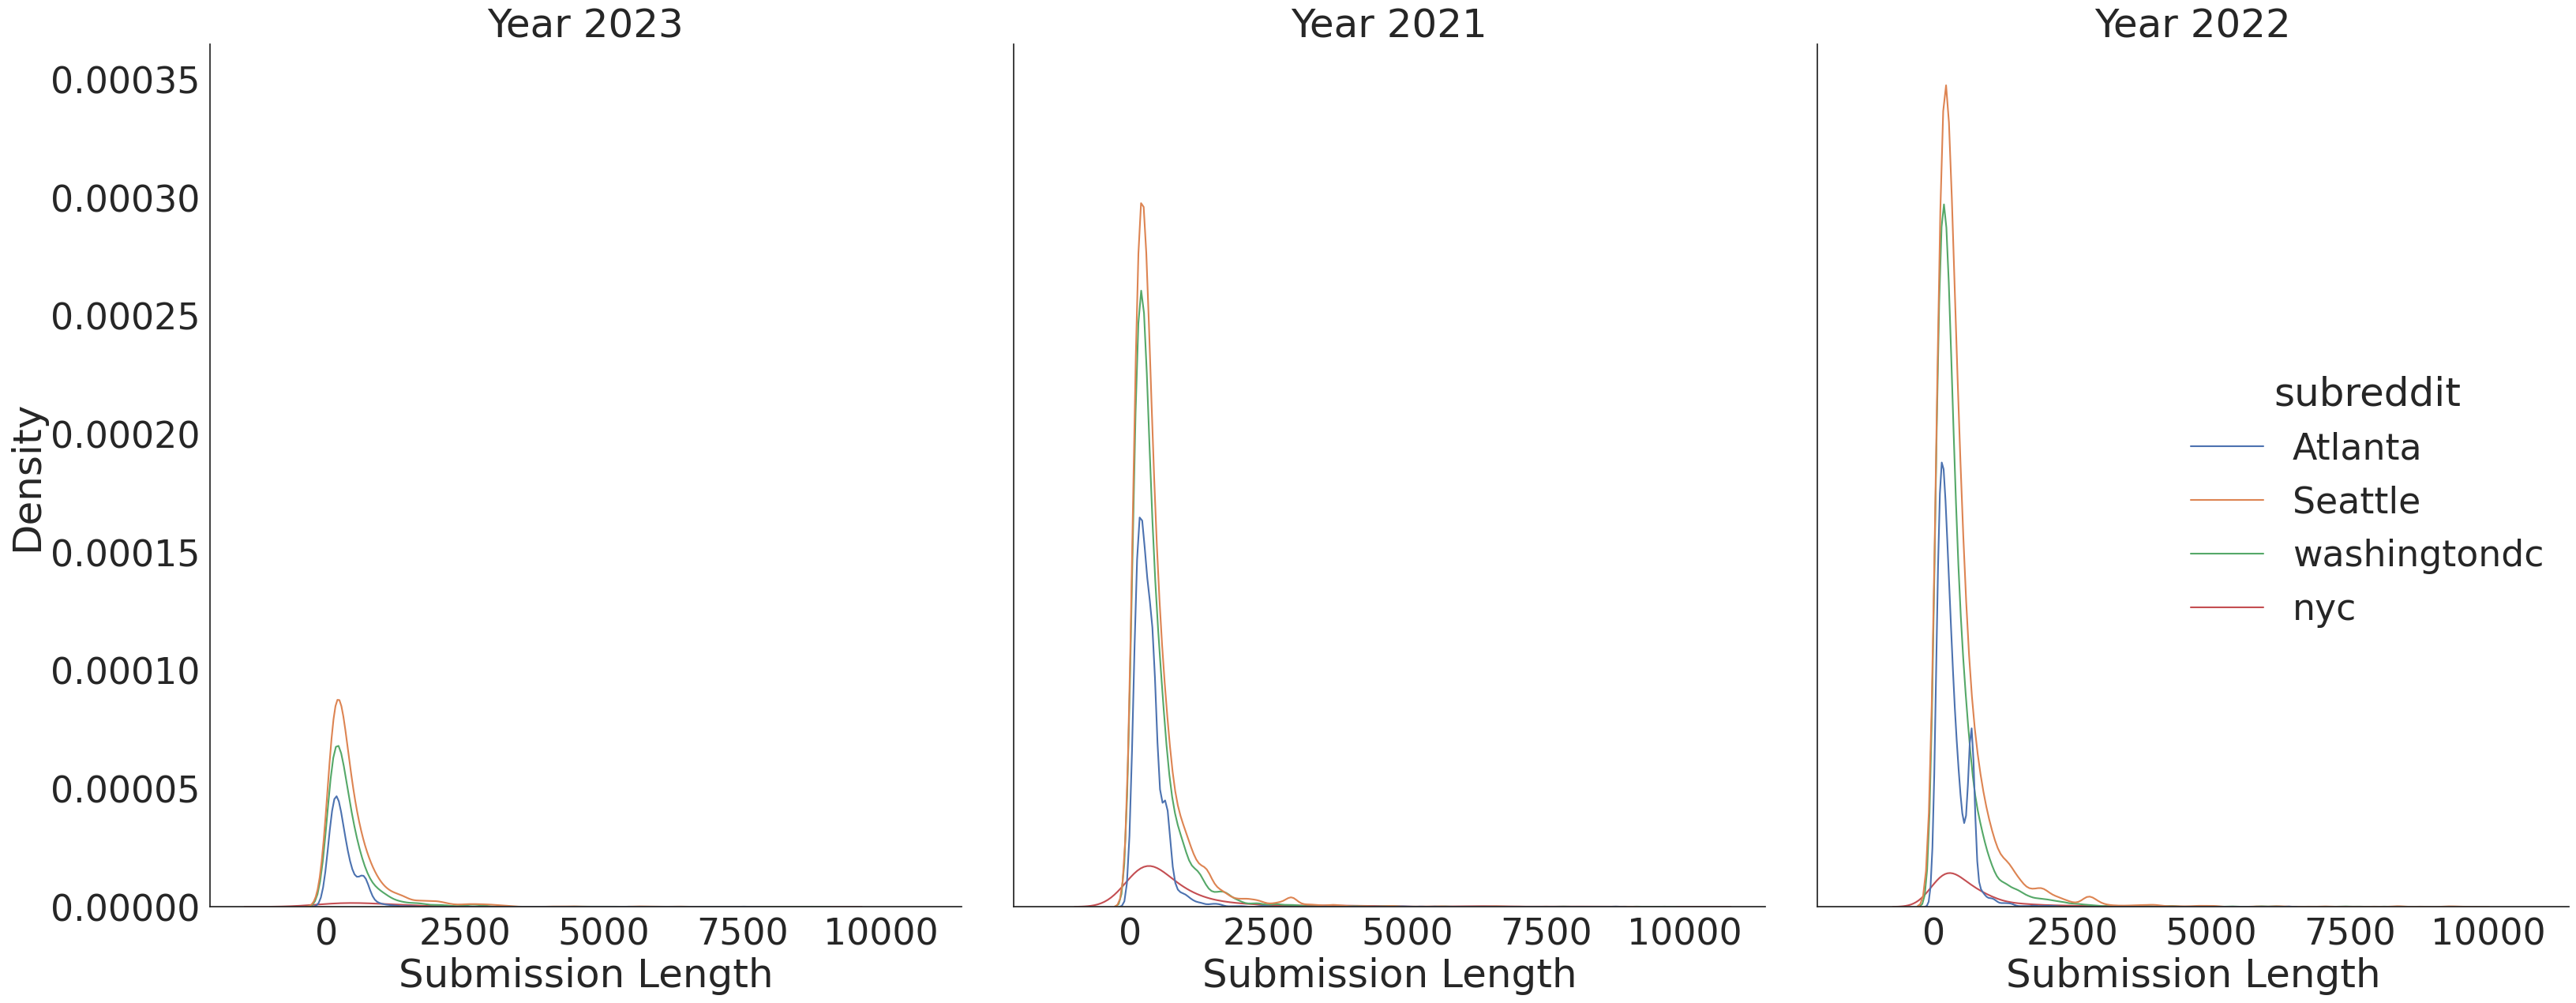

In [135]:
import matplotlib.pyplot as plt

sns.set(font_scale = 3, style='white')

g = sns.displot(data=new_df[new_df['raw_length'] <10000], 
            x="raw_length", 
            hue='subreddit',
            kind='kde',
            col='year',
            height=14, aspect=.67)

g.set_axis_labels("Submission Length", "Density")
g.set_titles("Year {col_name}")
g.fig.subplots_adjust(top=0.9, right=1)

**Analysis:** The distribution plots above show that across all years and all subreddits, the lengths of the submission text tends to stay below 1000 characters, with the mean centered around 0. Across the years, the distribution at these lengths tends to be high, with the exception for 2023 since the year's data was not complete. In all three plots, the Atlanta subreddit appeared to have a bimodal distribution where the curve showed two bell curves, one near zero and one near 1000. This means that in the Atlanta subreddit, some submission lengths were short, but many were also long .

In [136]:
g.savefig('/mnt/batch/tasks/shared/LS_root/mounts/clusters/mv7902/code/Users/fall-2023-reddit-project-team-02/code/wip_scripts/wip_images/mv_nlp_01.png')

## 3. Top Words by Frequency

In the following section, we are going to look at the top words in the submissions by frequency. Similar to the analysis above, this can be analyzed by looking at the top words across the subreddit type. Looking at the top words is essential in the preliminary text analysis because it may provide some insight into the topics discussed in the subreddit and hint at the types of sentiment in the data.

Since this is a preliminary view of the text data, we will be using a simple strategy of splitting the text (e.g., whitespace, new line). 

In [34]:
from collections import Counter
import re

def simple_tokenize_text(text):
    return re.split(r'\s+', text)

def collect_top_words(df):
    # Initialize dict
    #data = {'Year': [], 'Subreddit': [], 'Top Words': []}
    data = {'Subreddit': [], 'Top Words': []}
    # Initialize variables
    #years = df['year'].unique()
    subreddits = df['subreddit'].unique()
    # Iterate through each combination of year and subreddit
    #for year in years:
    for subreddit in subreddits:
        # Add year
        #data['Year'].append(year)
        # Add subreddit
        data['Subreddit'].append(subreddit)
        # Subset data
        #sub_df = df[(df['year']==year)&(df['subreddit']==subreddit)]
        sub_df = df[df['subreddit']==subreddit]
        # Make one large string
        texts = ' '.join(sub_df['selftext'])
        # Tokenize string
        texts = simple_tokenize_text(texts)
        # Find word frequency
        word_freq = Counter(texts)
        # Get the top 10 words
        data['Top Words'].append(dict(word_freq.most_common(10)))

    return pd.DataFrame(data)

In [35]:
top_words = collect_top_words(new_df)

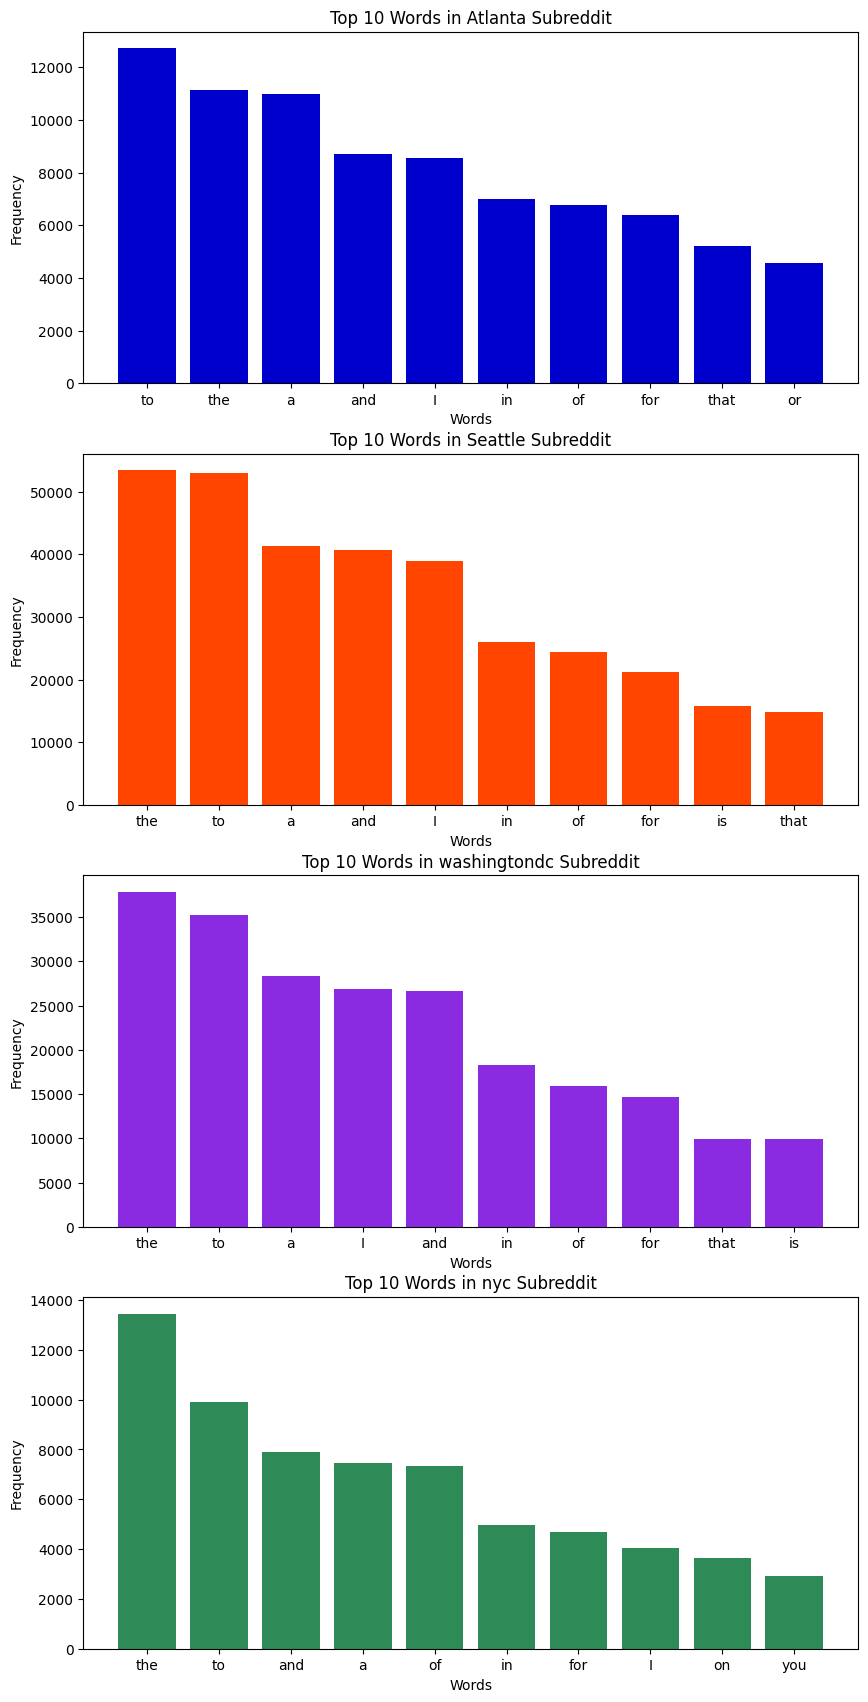

In [57]:
# Initialize colors
colors = ['mediumblue','orangered', 'blueviolet', 'seagreen']
fig, ax = plt.subplots(4,1, figsize = (10,21))

for i, val in enumerate(top_words['Subreddit']):
    ax[i].bar(*zip(*top_words['Top Words'][i].items()), color=colors[i])
    ax[i].set_title(f'Top 10 Words in {val} Subreddit')
    ax[i].set_xlabel('Words')
    ax[i].set_ylabel('Frequency')

**Analysis:** After visualizing the top words in the subreddits, it became clear that the most frequent words are stop words. Stopwords are words that occur in text frequently, but do not contribute to the meaning of it. Examples of this include words like "And" and "The". This exploration result shows that to get meaningful insights of the text data, we will need to include stopword removal as part of the NLP pipeline conducted later on.

In [58]:
fig.savefig('/mnt/batch/tasks/shared/LS_root/mounts/clusters/mv7902/code/Users/fall-2023-reddit-project-team-02/code/wip_scripts/wip_images/mv_nlp_02.png')

## 4. Top Words by TF-IDF

A better way to measure the top words in a body if text is TF-IDF. Term Frequency Inverse Document Frequency (TF-IDF) measures the importance of a word by looking at the word's frequency relative to its document. If a word is truly important, it will appear more across documents, not just one. Since stopwords appeared frequently in the previous visualization, they will be excluded in this section and in the rest of the NLP analysis.

In [14]:
!pip install wordcloud
!pip install nltk

     |████████████████████████████████| 461 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 5.2 MB/s eta 0:00:01


In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

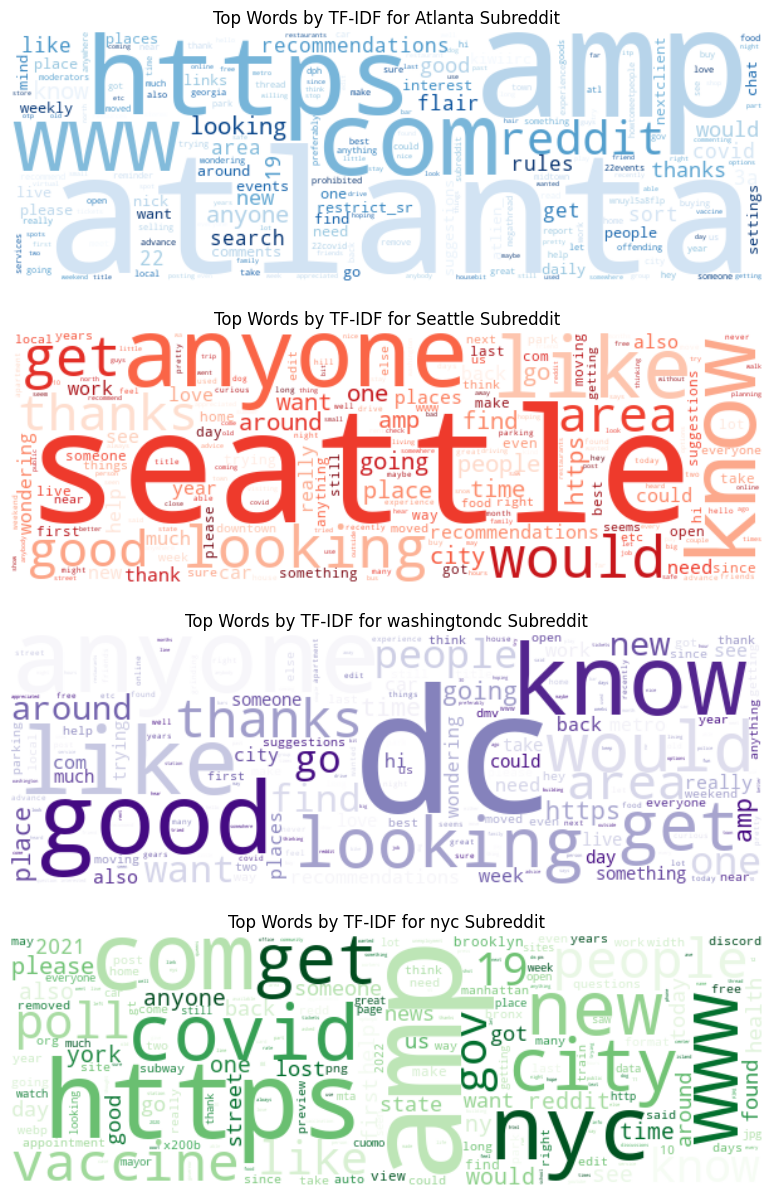

In [23]:
nltk_stopwords = set(stopwords.words('english'))

# Initialize TfidfVectorizer with NLTK stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=nltk_stopwords)

fig, ax = plt.subplots(4,1, figsize = (10,15))

# Colors for wordcloud
colors = ['Blues','Reds', 'Purples', 'Greens']

# Create separate word clouds for each subreddit
for i,subreddit in enumerate(new_df['subreddit'].unique()):
    # Subset df to be subreddit
    sub_df = new_df[new_df['subreddit']==subreddit]    
    text_data = sub_df['selftext'].dropna().astype(str)
    # Fit TF-IDF vectorizer
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)
    # Get words
    feature_names = tfidf_vectorizer.get_feature_names()
    # Sum up the TF-IDF scores for each word across all documents
    word_scores = tfidf_matrix.sum(axis=0).A1
    # Create a dictionary with words and their corresponding TF-IDF scores
    word_tfidf_scores = dict(zip(feature_names, word_scores))
    # Create a WordCloud object with TF-IDF scores as input
    wordcloud = WordCloud(width=600, height=200, background_color='white', colormap=colors[i]).generate_from_frequencies(word_tfidf_scores)
    
    # Plot wordloud
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title(f'Top Words by TF-IDF for {subreddit} Subreddit')
    ax[i].axis('off')

**Analysis:** The wordclouds above display the top words in the subreddits according to TF-IDF. It's no surprise that the top words appear to be the city names, which are the main topics of the subreddits. Words pertaining to geographical location such as "Streets" and "Places" tended to show up in the top words, which may be attributed to individuals inquiring about locations. Words like "Recommendation" were among the top words as well because people inquire about recommendations pertaining to restaurants or events. City-specific words, such as "DMV" (D.C., Maryland, Virginia) in the Washington, D.C. subreddit appeared as well. Another interesting finding is that words such as "19" and "vaccine" appeared in some of the subreddit top words, likely due to discourse surrounding the COVID-19 pandemic.

In [25]:
fig.savefig('/mnt/batch/tasks/shared/LS_root/mounts/clusters/mv7902/code/Users/fall-2023-reddit-project-team-02/code/wip_scripts/wip_images/mv_nlp_03.png')